In [1]:
# the class to hande histograms and some helper functions
import copy
import math
import os

def safediv(a,b):
    if float(b) != 0.:
        return a/b
    else:
        return float('nan')
    
def removenan(llist, newv = 0.):
    for i, v in enumerate(llist):
        if math.isnan(v):
            llist[i] = newv
    return llist
        

def get_histo_from_file(fname, hname, htype, nrebin=1, fixrate=False, totrate=0., scvarfiles = []):
    content = open(fname).read()
    found = False
    xmin = []
    xmax = []
    y = []
    yerr = []
    scvars = {0.5:[], 2.:[]}
    
    for l in content.split('\n'):

        if l.startswith("<histogram>") and l.split('"')[1].strip().startswith(hname) and \
        ('TYPE@%s|' % htype in l or 'TYPE@%s"' % htype in l or '|T@%s ' % htype in l):
            found = True
            continue
        if found and l.startswith("<\\histogram>"):
            break
        if found:
            values = [float(v) for v in l.split()]
            xmin.append(values[0])
            xmax.append(values[1])
            y.append(values[2])
            yerr.append(values[3])
            if not scvarfiles and len(values) == 16:
                scvars[0.5].append(values[15])
                scvars[2.].append(values[12])
            elif scvarfiles:
                scvars[0.5] = get_histo_from_file(scvarfiles[0], hname, htype, nrebin, fixrate, totrate)['y']
                scvars[2] = get_histo_from_file(scvarfiles[1], hname, htype, nrebin, fixrate, totrate)['y']


    if not found:
        print('Not found, ', fname, hname, htype)
        raise HistoNotFound('get_histo_from_file, not found', fname, hname, htype)
    return Histogram(xmin, xmax, y, yerr, scvars, fixrate, totrate).rebin(nrebin)


def get_histo_from_datfile(fname, nevents=1., nrebin=1):
    content = open(fname).read()
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):
        if not(l): continue
        if l.startswith('#') or l.strip().startswith('No'): continue
        values = [float(v) for v in l.split()]
        xmin.append(values[0])
        xmax.append(values[1])
        y.append(values[2]/nevents)
        if values[3] != 0:
            yerr.append(values[2]/math.sqrt(values[3])/nevents)
        else:
            yerr.append(0)

    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)
            
class HistoNotFound(Exception):
    pass

class Histogram(dict):
    def __init__(self, xmin, xmax, y, yerr, scvars = {}, fixrate=False, rate=0.):
        if not (len(xmin)==len(xmax)==len(y)==len(yerr)):
            raise Exception('Init, Invalid size')
                
        self['xmin'] = xmin
        self['xmax'] = xmax
        self['x'] = [(x1+x2)/2 for x1,x2 in zip(xmin,xmax)]
        self['xlo'] = xmin
        self['xhi'] = xmax
        self['y'] = y
        self['yerr'] = yerr
        self['nbins'] = len(xmin)
        self['scvars'] = scvars
        
        if fixrate:
            # this is for mtt, with issues related to overflow in the last bin
            # change the rate of the last bin so that the total rate of
            # the histogram is equal to rate
            self['y'][-1] += rate - self.totrate
                
    
    def __add__(self, other):
        if type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('add, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('add, Invalid x')
            return Histogram(self['xmin'], self['xmax'],
                        [y1+y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(y1**2+y2**2) for y1,y2 in zip(self['yerr'], other['yerr'])],
                        scvars = dict([(k,[v1+v2 for v1,v2 in zip(self['scvars'][k],other['scvars'][k])]) for k in self['scvars'].keys() ]))
        elif type(other) in [int, float]:
            if self['scvars']: print('sum, warning, scvars not implemented')
            return Histogram(self['xmin'], self['xmax'],
                        [y1+other for y1 in self['y']],
                        self['yerr'])
        else:
            raise(Exception, 'invalid type %s' % type(other))
            
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    
    
    def __mul__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1*other for y1 in self['y']],
                        [y1*other for y1 in self['yerr']],
                            scvars = dict([(k,[v*other for v in self['scvars'][k]]) for k in self['scvars'].keys() ]))
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('mul, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('mul, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            if self['scvars']: print('mul, warning, scvars not implemented')
            return Histogram(self['xmin'], self['xmax'],
                        [y1*y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt((y1*e2)**2 + (e2*y1)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])])
            
        else:
            raise Exception('mul, not implemented')
            
            
    def __truediv__(self, other):
        """ if there are scale variations, divide the scale variations of self by the central value of other"""
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1/other for y1 in self['y']],
                    [y1/other for y1 in self['yerr']],
                     scvars = dict([(k,[v/other for v in self['scvars'][k]]) for k in self['scvars'].keys() ]))
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('div, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('div, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            return Histogram(self['xmin'], self['xmax'],
                        [safediv(y1,y2) for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(safediv(e1,y2)**2+(safediv(y1,y2**2)*e2)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])],
                            scvars = dict([(k,[safediv(v,y) for v, y in zip(self['scvars'][k],other['y'])]) for k in self['scvars'].keys() ]))
            
        else:
            raise Exception('div, not implemented')
            
    
    def rebin(self, nbins):
        if (self['nbins']//nbins)*nbins != self['nbins']:
            print('cannot rebin')
            return self
        if nbins == 1:
            return self
        xmin = []
        xmax = []
        y = []
        yerr = []
        for i in range(self['nbins']//nbins):
            i0 = i * nbins
            i1 = (i+1) * nbins  - 1
            xmin.append(self['xmin'][i0])
            xmax.append(self['xmax'][i1])
            y.append(sum(self['y'][i0:i1+1]))
            yerr.append(math.sqrt(sum([err**2 for err in self['yerr'][i0:i1+1]])))
        
        return Histogram(xmin,xmax,y,yerr)
    
    def replacefirstbins(self, other, xx):
        ### replace the first bins of self (with x < xx) with those of others
        if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
            raise Exception('Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
        
        #find the first x > xx
        for i, x in enumerate(self['x']):
            if x > xx:
                break
        self['y'] = other['y'][:i] + self['y'][i:]
        self['yerr'] = other['yerr'][:i] + self['yerr'][i:]   
    
    def maxv_n(self, i):
        """return the next^i to maximum"""
        values = sorted(self['y'], reverse=True)
        return values[i]
    
    @property
    def maxv(self):
        return max(self['y'])
    
    @property
    def totrate(self):
        return sum(self['y'])
        
    @property
    def minv(self):
        return min([v for v in self['y'] if v not in [0, -100]])
    
    def scalelow(self, inflate=1):
        """inflate makes it possible to artificially enlarge the scale variation"""
        new_scvars = {0.5: [y+(s-y)*inflate for s, y in zip(self['scvars'][0.5], self['y'])],
                      2.: [y+(s-y)*inflate for s, y in zip(self['scvars'][2.], self['y'])]}
        return removenan([min([v1,v2,y]) for v1, v2, y in zip(new_scvars[0.5],new_scvars[2.],self['y'])])
    
    def scalehig(self, inflate=1):
        new_scvars = {0.5: [y+(s-y)*inflate for s, y in zip(self['scvars'][0.5], self['y'])],
                      2.: [y+(s-y)*inflate for s, y in zip(self['scvars'][2.], self['y'])]}
        return removenan([max([v1,v2,y]) for v1, v2, y in zip(new_scvars[0.5],new_scvars[2.],self['y'])])
    
    def scaledelta(self, inflate=1):
        return [v1-v2 for v1,v2 in zip(self.scalehig(inflate), self.scalelow(inflate))]


In [48]:
# matplotlib setup and some definitions
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
lw = 1.2
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'
import matplotlib.font_manager as font_manager
import matplotlib.backends.backend_pdf as backend_pdf
from matplotlib.ticker import MultipleLocator,AutoMinorLocator

import matplotlib as mpl
#mpl.rcParams.update({"mathtext.fontset": "dejavuserif"})
mpl.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 14})
mpl.rcParams.update({'lines.markersize': 8})
#mpl.rcParams.update({'lines.linewidth': 0.5})
markers_glob = ['o', 'v', 's', '<', '>', 's', 'p', '*', 'h', 'p', 'x', 'X', 'd']
font_legend = font_manager.FontProperties(size=9)

def update_legend(ax, ncol, pos = None):
    # this is to have the line in the legend, and not the square
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for i, h in enumerate(handles):
        ls = h.get_linestyle()
        lc = h.get_edgecolor()
        #mk = markers[i]
        if ls == 'dashed':
            facecolor = 'none'
        else:
            facecolor = lc
        #new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, marker = mk, markerfacecolor = facecolor))
        new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, markerfacecolor = facecolor))

    if not pos:
        pos = (1,1.1)
    if pos == 'auto':
        ax.legend(handles=new_handles, labels=labels, prop=font_legend, frameon = False, ncol=ncol,
                 loc='best')
    else:
        ax.legend(handles=new_handles, labels=labels, prop=font_legend, frameon = False, ncol=ncol,
              loc='upper left', bbox_to_anchor=pos)


xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}





tt 3 mtt
tt 3 pttop
tt 10 mtt
tt 10 pttop
ww 3 mtt
ww 3 pttop
ww 10 mtt
ww 10 pttop


FileNotFoundError: [Errno 2] No such file or directory: 'ww/massive_madevent/histo_pttop_10tev_ymax5_biasptt4_new_PTBIN1.dat'

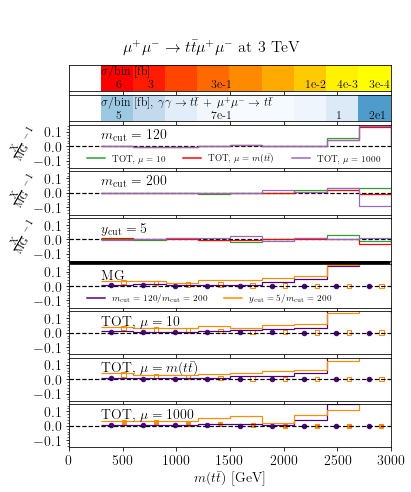

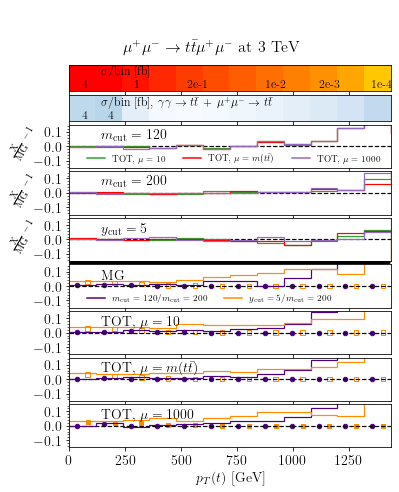

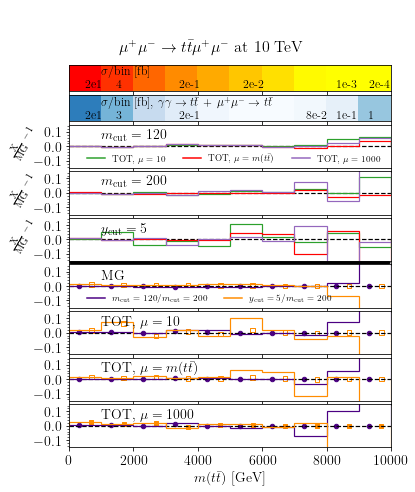

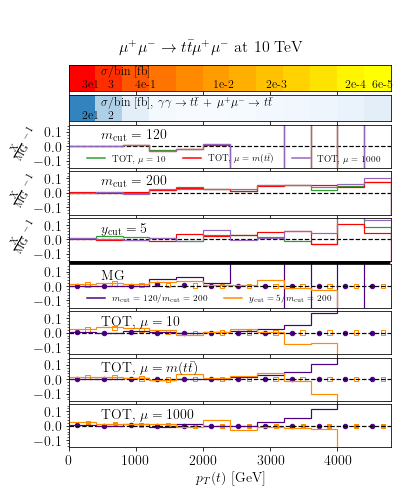

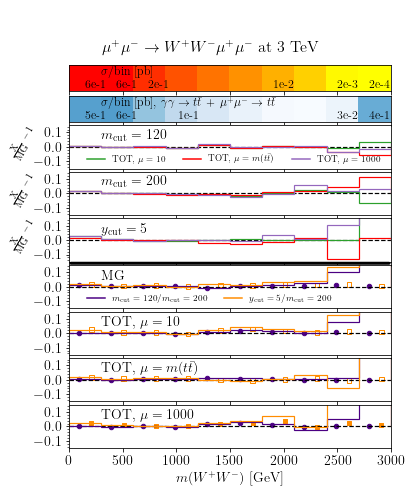

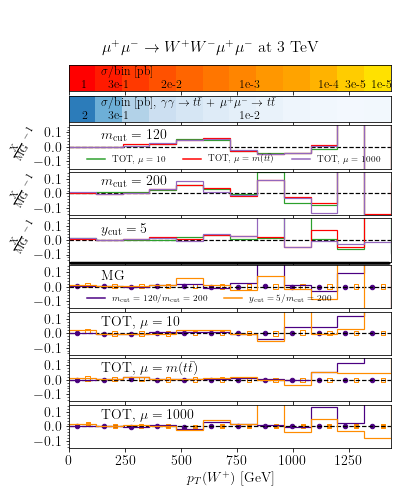

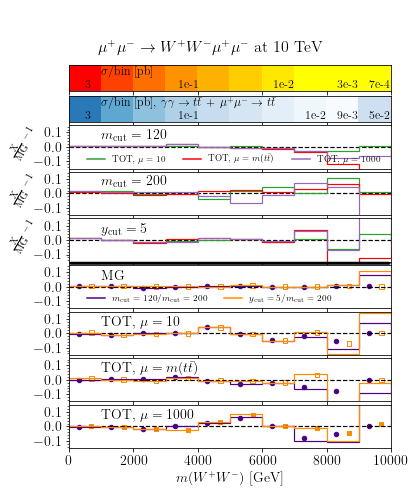

In [83]:
# Main plots for the technical paper
# mtt, compare m[mumu]>200 with ycuts
from matplotlib.colors import LogNorm
nrebin = 5 
import math
import itertools


def get_label_pos(histo, ypos=0.5):
    """find the label positions where the log10 of the xsection per bin increases by one unity
    always move towards the maximum"""
    imax = histo['y'].index(max(histo['y']))
    # from the left to the right
    lastlog = -20
    labels_left = []
    labels_left.append((histo['x'][imax], ypos, histo['y'][imax]))
    # from the left to the max
    for x, y in zip(histo['x'][:imax], histo['y'][:imax]):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))
            #labels_left.append((x, ypos, 10.**lastlog))
            labels_left.append((x, ypos, y))
    labels_right = []
    # from the right to the max
    lastlog=-20
    for x, y in reversed(list(zip(histo['x'][imax+1:], histo['y'][imax+1:]))):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))

            #labels_right.append((x, ypos,10.**lastlog))
            labels_right.append((x, ypos,y))
    return labels_left + list(reversed(labels_right))

def lint(v):
    """returns the largest integer i for which i < v """
    if v > 0:
        return int(v)
    else:
        return int(v) - 1

def put_labels(ax, labels, color='w', fontsize=11, rotation=0):
    for x, y, v in labels:
        #if int(v) != 0:
        #    ss = '%d' % v
        #elif int(v*10) !=0:
        #    ss = '%.1f' % v
        #    ss = ss[1:]
        #elif int(v*100) !=0:
        #    ss = '%.2f' % v
        #    ss = ss[1:]
        #elif int(v*1000) !=0:
        #    ss = '%.3f' % v
        #    ss = ss[1:]
        #elif int(v*10000) !=0:
        #    ss = '%.4f' % v
        #    ss = ss[1:]
        #else:
        #    ss = 'AAAA'
        ss = "%.0e" % v
        ss = ss.replace('e+00', '')
        ss = ss.replace('+0', '')
        ss = ss.replace('-0', '-')
        ax.annotate(ss, xy = (x*0.98,y), color = color, fontsize= fontsize, rotation=rotation)
    
            
allcolors[6] = 'darkorange'
allcolors[5] = 'indigo'        
    
for p, en, o in itertools.product(['tt', 'ww'], [3,10], ['mtt', 'pttop']):
#for p, en, o in itertools.product(['ww'], [3], ['mtt']):

#for p, en in itertools.product(['tt',], [3,10]):
    print(p, en, o)
    fname_mg_m200 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_biasmtt4_new.dat' % (o, en))
    if en==10:
        fname_mg_m200_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt2_new.dat' % en)
    fname_nnlo1000_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m200 = os.path.join(p, 'run_%dtev_comparemassive_mumtt' % en, 'MADatNLO.HwU')
    
    fname_mg_y5 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_ymax5_biasmtt4_new.dat' % (o, en))
    if en ==10:
        fname_mg_y5_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt2_new.dat' % en)
              
    fname_nnlo1000_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mumtt' % en, 'MADatNLO.HwU')

    fname_nnlo1000_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mumtt' % en, 'MADatNLO.HwU')
    
    if en != 10:
        fname_mg_m120 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasmtt4_new.dat' % (o, en))
    else:
        fname_mg_m120 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasmtt2_new.dat' % (o, en))

    if en ==10:
        fname_mg_m120_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_mcut120_biasmtt2_new.dat' % en)     
    
    if en == 10 and o == 'pttop':
        fname_mg_y5 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_ymax5_biasptt4_new_PTBIN%d.dat' % (o, en, ib+1)) 
                       for ib in range(5)] 
        fname_mg_m200 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_biasptt2_new_PTBIN%d.dat' % (o, en, ib+1)) 
                       for ib in range(5)] 
        fname_mg_m120 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasptt2_new_PTBIN%d.dat' % (o, en, ib+1)) 
                       for ib in range(5)] 
        #fname_mg_m120 = [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_nobias_new_PTBIN%d.dat' % (o, en, ib+1)) 
        #               for ib in range(4)] + [os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_nobias_new_PTBIN45.dat' % (o, en))] 
                       
    fname_lotot = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil' % en, 'MADatNLO.HwU')
    
    if o == 'mtt':
        obsrange = (0,en*1000)
        nrebin = 5
    if o == 'pttop':
        obsrange = (0,en*1000/2 * 12/12.5)
        nrebin = 2
        
    #histograms
    
    if en == 10 and o == 'pttop':
        hlist = [get_histo_from_datfile(f, 5e5, nrebin) for f in fname_mg_y5]
        h_mg_y5 = hlist[0]
        for h in hlist[1:]:
            h_mg_y5 += h
        hlist = [get_histo_from_datfile(f, 5e5, nrebin) for f in fname_mg_m200]
        h_mg_m200 = hlist[0]
        for h in hlist[1:]:
            h_mg_m200 += h
        hlist = [get_histo_from_datfile(f, 5e5, nrebin) for f in fname_mg_m120]
        h_mg_m120 = hlist[0]
        for h in hlist[1:]:
            h_mg_m120 += h        
    else:
        h_mg_y5 = get_histo_from_datfile(fname_mg_y5, 1e6, nrebin)
        h_mg_m120 = get_histo_from_datfile(fname_mg_m120, 1e6, nrebin)
        h_mg_m200 = get_histo_from_datfile(fname_mg_m200, 1e6, nrebin)
    
    if en == 10 and o == 'mtt':
        h_mg_m120_other = get_histo_from_datfile(fname_mg_m120_other, 1e6, nrebin)
        h_mg_m200_other = get_histo_from_datfile(fname_mg_m200_other, 1e6, nrebin)
        h_mg_y5_other = get_histo_from_datfile(fname_mg_y5_other, 1e6, nrebin)
        h_mg_m120.replacefirstbins(h_mg_m120_other, 2001.)
        h_mg_m200.replacefirstbins(h_mg_m200_other, 2001.)
        h_mg_y5.replacefirstbins(h_mg_y5_other, 2001.)
    
    h_nnlo_1000_m200 = get_histo_from_file(fname_nnlo1000_m200, o, 'TOT', nrebin)
    h_nnlo_1000_y5 = get_histo_from_file(fname_nnlo1000_y5, o, 'TOT', nrebin)
    h_nnlo_1000_m120 = get_histo_from_file(fname_nnlo1000_m120, o, 'TOT', nrebin)
    
    h_nnlo_mtt_m200 = get_histo_from_file(fname_nnlomtt_m200, o, 'TOT', nrebin)
    h_nnlo_mtt_y5 = get_histo_from_file(fname_nnlomtt_y5, o, 'TOT', nrebin)
    h_nnlo_mtt_m120 = get_histo_from_file(fname_nnlomtt_m120, o, 'TOT', nrebin)

    h_nnlo_10_m200 = get_histo_from_file(fname_nnlo10_m200, o, 'TOT', nrebin)
    h_nnlo_10_y5 = get_histo_from_file(fname_nnlo10_y5, o, 'TOT', nrebin)
    h_nnlo_10_m120 = get_histo_from_file(fname_nnlo10_m120, o, 'TOT', nrebin)
        
    h_lotot = get_histo_from_file(fname_lotot, o, 'LO', nrebin)
    h_loaa = get_histo_from_file(fname_lotot, o, 'LOAA', nrebin)
    h_ratio_loaa = h_loaa/h_lotot

    # now the figure
    fig, axes = plt.subplots(nrows = 9, ncols= 1, sharex = True, 
                                         gridspec_kw={'height_ratios': [1.2,1.2,2,2,2,2,2,2,2]})
    fig.set_size_inches(7*0.75,7)
    fig.suptitle("\n\n" + "    " + proc_string[p] + '$\\mu^+\\mu^-$' + ' at %d TeV' % en, fontsize=16, y=1.00) 
        
    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(obsrange[0],obsrange[1])
        
    # first inset, ratio with the m(200) cut wrt MG
    ax = axes[0]
    #ax.set_ylim(0.85,1.15)
    #h_ratio = h_mg_m200/h_mg_m200
    if p == 'tt':
        unit = 1000. # convert to fb
        sunit = 'fb'
    elif p == 'ww':
        unit = 1. #stay in pb
        sunit = 'pb'
    
    heatmap=ax.pcolor([h_mg_m200['x']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [[y*unit for y in h_mg_m200['y']]]*2,
             norm=LogNorm(vmin=h_mg_m200.minv*unit*10, vmax=h_mg_m200.maxv*unit), cmap='autumn_r', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_mg_m200*unit,-0.25), color='black', fontsize=12)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$' % sunit, xy = (obsrange[1]/10,0.75), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)
    
    ax = axes[1]
    heatmap=ax.pcolor([h_lotot['x']]*2, [[0]*h_lotot['nbins'], [1]*h_lotot['nbins']], [[y*unit for y in h_lotot['y']]]*2,
             norm=LogNorm(vmin=h_lotot.minv*unit, vmax=h_lotot.maxv*unit*10), cmap='Blues', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_lotot*unit,-0.25), color='black', fontsize=12)#, rotation=65)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$, $\\gamma\\gamma\\to t\\bar t\\, +\\,\\mu^+\\mu^- \\to t\\bar t$' % sunit, xy = (obsrange[1]/10,0.75), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)

    ax = axes[2]
    ax.set_ylim(-0.15,0.15)
    ax.set_ylabel('$\\frac{\\textrm{X}}{\\textrm{MG}}-1$', fontsize=10, rotation=60)
    ax.text(obsrange[1]/10, 0.05, '$m_{\\rm cut} = 120$')

    h_ratio = h_nnlo_10_m120/h_mg_m120 - 1 
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000), 
            label = '${\\textrm{TOT},\\,\\mu=10}$')
                #label = '${\\textrm{TOT},\\,\\mu=10}/{\\textrm{MG}} -1$')

    h_ratio = h_nnlo_mtt_m120/h_mg_m120 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000), 
            label = '${\\textrm{TOT},\\,\\mu=m(t\\bar t)}$')
    h_ratio = h_nnlo_1000_m120/h_mg_m120 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000), 
            label = '${\\textrm{TOT},\\,\\mu=1000}$')
    update_legend(ax, ncol=3, pos=(0.03,0.5))

    ax = axes[3]
    ax.set_ylabel('$\\frac{\\textrm{X}}{\\textrm{MG}}-1$', fontsize=10, rotation=60)

    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, '$m_{\\rm cut} = 200$')

    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    h_ratio = h_nnlo_10_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000),)
    h_ratio = h_nnlo_mtt_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000),)
    h_ratio = h_nnlo_1000_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000),)

   
    # third inset, ratio with the y=5 cut wrt MG
    ax = axes[4]
    ax.set_ylabel('$\\frac{\\textrm{X}}{\\textrm{MG}}-1$', fontsize=10, rotation=60)

    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, '$y_{\\rm cut}=5$')
    h_ratio = h_mg_y5/h_mg_y5
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))

    h_ratio = h_nnlo_10_y5/h_mg_y5 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000),)
    h_ratio = h_nnlo_mtt_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000),)
    h_ratio = h_nnlo_1000_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000),)
    

    #ratios y=2.5 , y=5 /m200, madgraph
    ax = axes[5]
    # put a thick line above
    ax.annotate('', xy=(0.0, 1.04), xycoords='axes fraction', xytext=(1., 1.04), arrowprops=dict(arrowstyle="-", color='black', 
                                                                                             linewidth='3'))
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'MG')
    h_ratio = h_mg_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_mg_m120/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = '${m_{\\rm cut}=120}/{m_{\\rm cut}=200}$')
    h_ratio = h_mg_y5/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = '${y_{\\rm cut}=5}/{m_{\\rm cut}=200}$')

    h_ratio_aa = h_ratio_loaa * (h_mg_m120/h_mg_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_mg_y5/h_mg_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    update_legend(ax, ncol=2, pos=(0.03,0.5))
    
    
    #ratios y=2.5 , y=5 /m200, NNLO mu10
    ax = axes[6]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'TOT, $\\mu=10$')
    h_ratio = h_nnlo_10_m200/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_m120/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_10_y5/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    
    h_ratio_aa = h_ratio_loaa * (h_nnlo_10_m120/h_nnlo_10_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_10_y5/h_nnlo_10_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    #ratios y=2.5 , y=5 /m200, NNLO mumtt
    ax = axes[7]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'TOT, $\\mu =m(t\\bar t)$')
    h_ratio = h_nnlo_mtt_m200/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')

    h_ratio_aa = h_ratio_loaa * (h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    
    #ratios y=2.5 , y=5 /m200, NNLO mu1000
    ax = axes[8]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'TOT, $\\mu=1000$')
    h_ratio = h_nnlo_1000_m200/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_1000_m120/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_1000_y5/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')

    h_ratio_aa = h_ratio_loaa * (h_nnlo_1000_m120/h_nnlo_1000_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_1000_y5/h_nnlo_1000_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', color = allcolors[6], s = 20)
    
    
    ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])
    plt.savefig('check_massive2_%s_%s_%dtev.pdf'  % (p,o,en), bbox_inches = 'tight')


cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 1 mtt tt 0.16763638513 0.16749933169
TOTAL 1 pttt tt 0.16763638270399997 0.16749933637799996
TOTAL 1 pttop tt 0.16763638094 0.16749933544
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 1 mtt tt 0.17774551168 0.17771517268
TOTAL 1 pttt tt 0.17774551392600002 0.17771516789100003
TOTAL 1 pttop tt 0.17774551671 0.1777151695
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 3 mtt tt 0.028263800229999997 0.028440627340000003
TOTAL 3 pttt tt 0.028263800283 0.028440626653200005
TOTAL 3 pttop tt 0.02826380061 0.02844062722
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 3 mtt tt 0.031477234039999996 0.031546309349999996
TOTAL 3 pttt tt 0.0314772333314 0.0315463095865
TOTAL 3 pttop tt 0.03147723421 0.031546309620000004
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 10 mtt tt 0.027722424601 0.030045813455
TOTAL 10 pttt tt 0.027722425066300002 0.030045813566099998
TOTAL 10 pttop tt 0.027722424656 0.03

<ipython-input-81-822ebcd89b4b>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True,


TOTAL 1 pttop ww 3.099564959 3.0999227630000004


FileNotFoundError: [Errno 2] No such file or directory: 'ww/run_1tev_NLO_mumtt_03permil_novirt_cuts/MADatNLO.HwU'

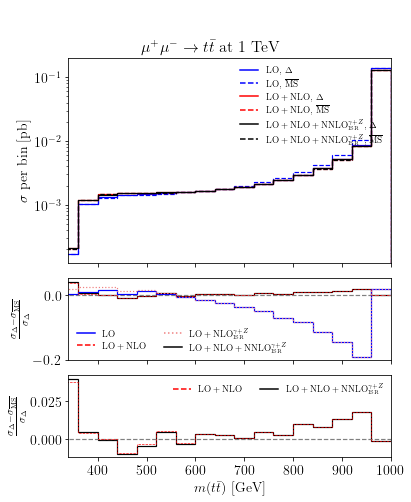

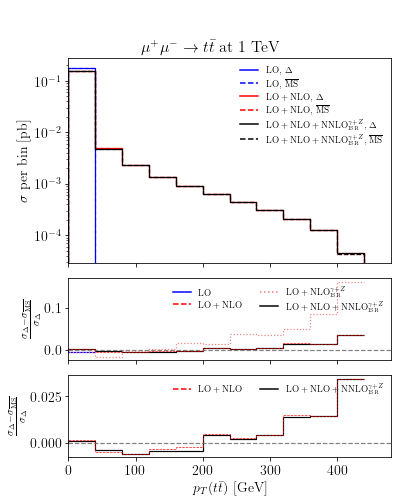

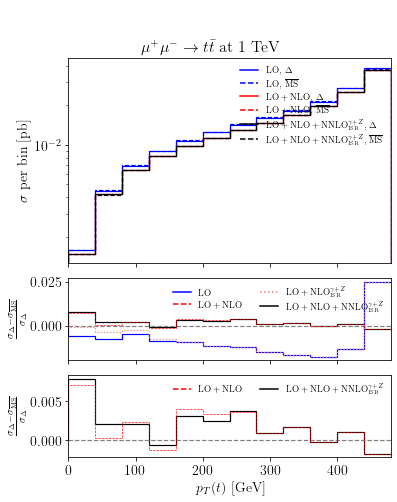

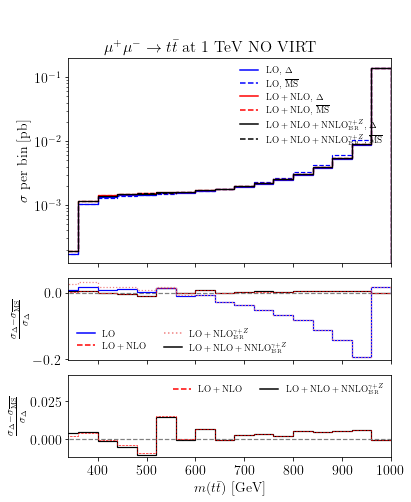

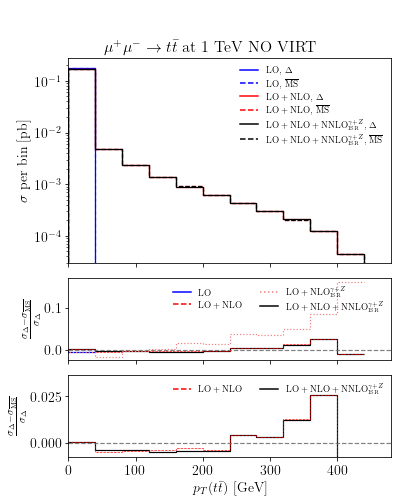

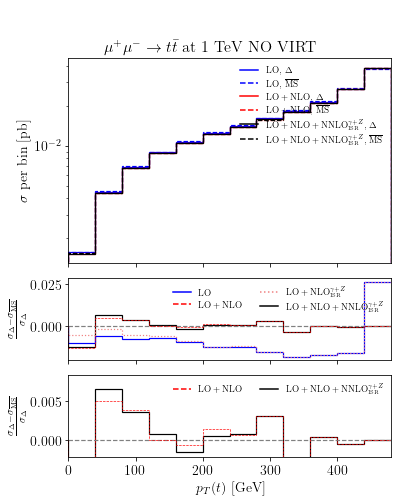

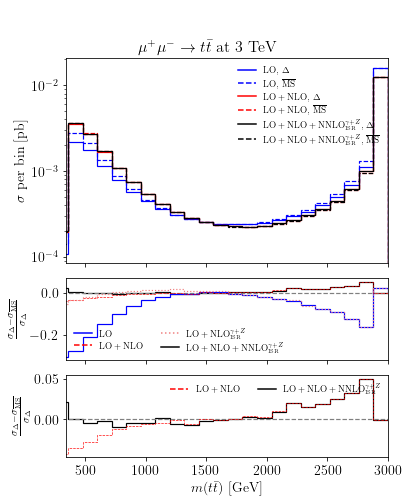

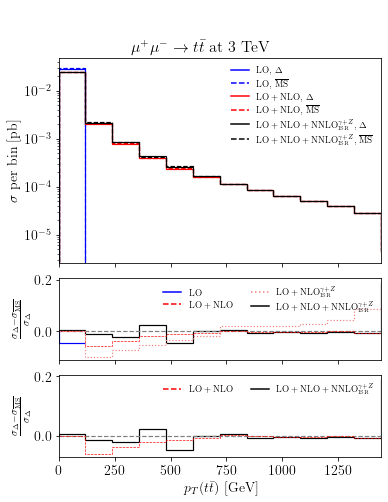

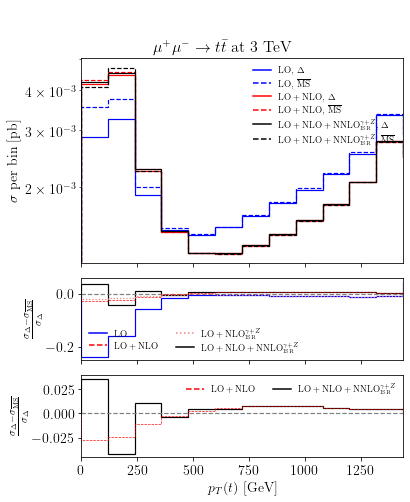

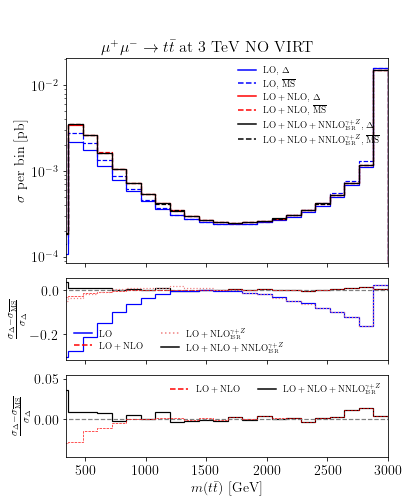

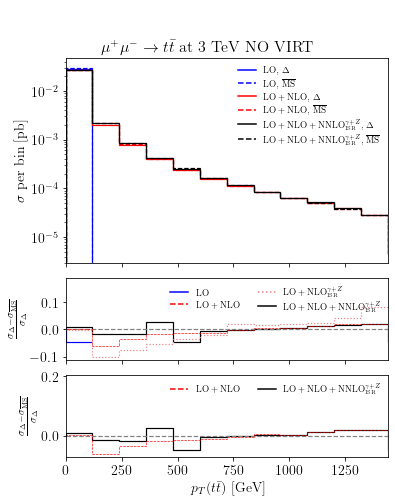

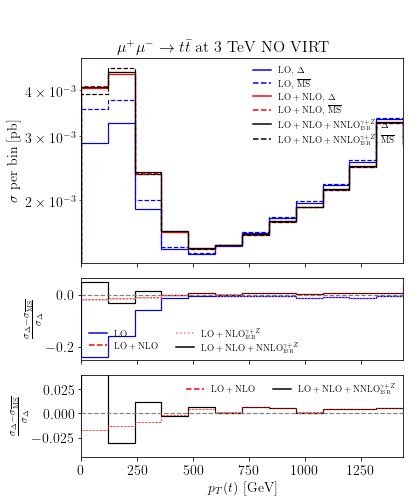

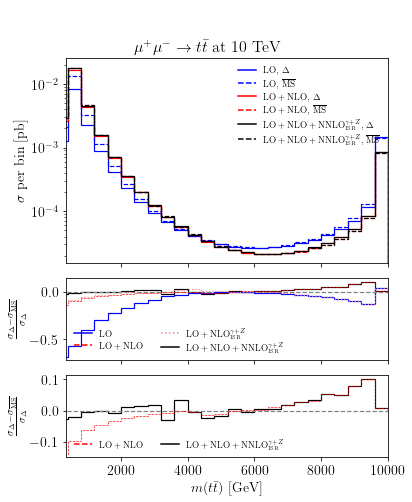

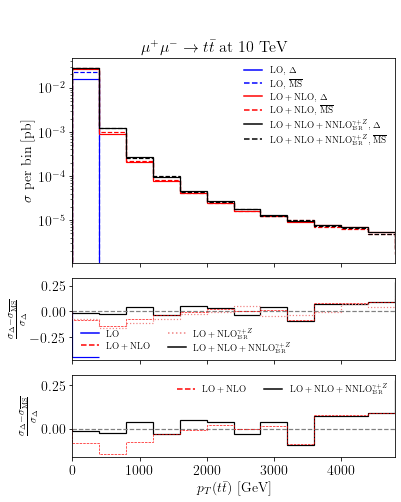

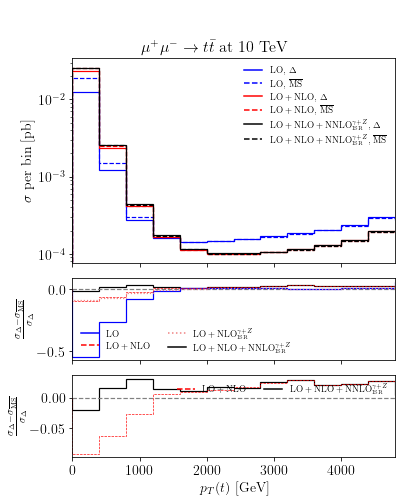

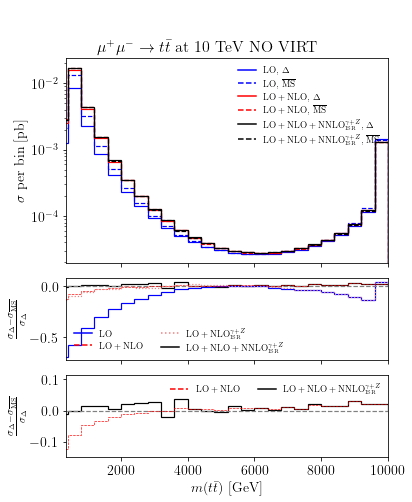

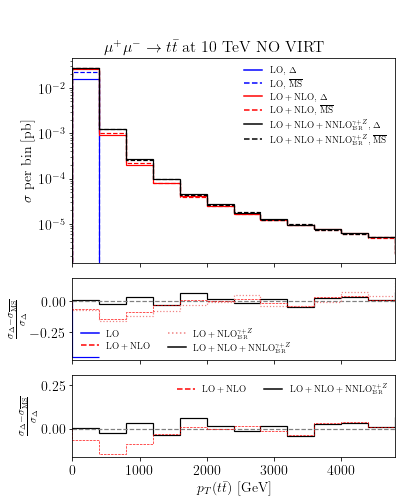

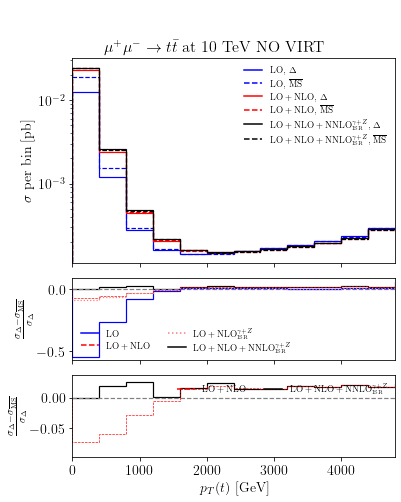

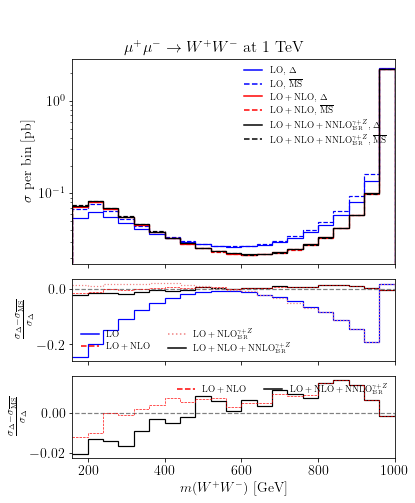

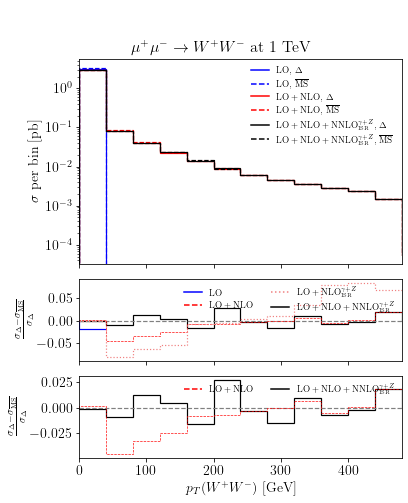

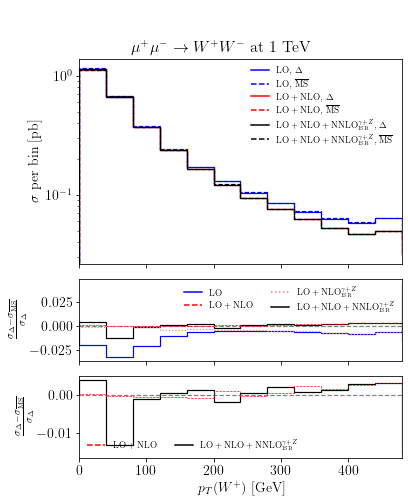

In [81]:
## msbar vs delta
import itertools


energies = [1,3,10]
observables = ['mtt', 'pttt', 'pttop', 'top rap', 'tt rap']
observables = ['mtt', 'pttt', 'pttop']

#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']
#processes = ['ww',]
#energies = [3]


xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}

allcolors[3] = 'black'
allcolors[1] = 'blue'
allcolors[2] = 'red'
allcolors[4] = 'lightcoral'

nrebin = 2

ylim_dict = {}

for p in processes:
    for (en, virt) in itertools.product(energies, [True, False]):
        if virt:
            novirt = ''
        else:
            novirt = '_novirt'
        fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil%s_cuts' % (en,novirt), 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_cuts' % en, 'MADatNLO.HwU')

        fname_mg_msb = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil%s_cuts' % (en,novirt), 'MADatNLO.HwU')
        fname_nnlo_msb = os.path.join(p, 'run_nnlo%d_fixqp_msb_mufmtt_cuts' % en, 'MADatNLO.HwU')

        rate_mg_lo = get_histo_from_file(fname_mg, 'total rate', 'LO', nrebin).totrate
        rate_mg_tot = get_histo_from_file(fname_mg, 'total rate', 'TOT', nrebin).totrate

        rate_mg_msb_lo = get_histo_from_file(fname_mg_msb, 'total rate', 'LO', nrebin).totrate
        rate_mg_msb_tot = get_histo_from_file(fname_mg_msb, 'total rate', 'TOT', nrebin).totrate

        for o in observables:
            #DELTA
            # mg histograms
            fixrate = (o == 'mtt')

            h_lo_mg = get_histo_from_file(fname_mg, o, 'LO', nrebin)#, fixrate, rate_mg_lo)
            h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA', nrebin)
            h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO', nrebin)
            h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR', nrebin)
            h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT', nrebin)#, fixrate, rate_mg_tot)
            # nnlo histograms
            h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO', nrebin)
            h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO', nrebin)
            h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO', nrebin)

            #MSBAR
            # mg histograms
            h_lo_mg_msb = get_histo_from_file(fname_mg_msb, o, 'LO', nrebin)#, fixrate, rate_mg_msb_lo)
            h_loaa_mg_msb = get_histo_from_file(fname_mg_msb, o, 'LOAA', nrebin)
            h_nlo_mg_msb = get_histo_from_file(fname_mg_msb, o, 'NLO', nrebin)
            h_nlor_mg_msb = get_histo_from_file(fname_mg_msb, o, 'NLOR', nrebin)
            h_tot_mg_msb = get_histo_from_file(fname_mg_msb, o, 'TOT', nrebin)#, fixrate, rate_mg_msb_tot)
            # nnlo histograms
            h_lo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'LO', nrebin)
            h_nlo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'NLO', nrebin)
            h_nnlo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'NNLO', nrebin)


            # now the figure
            fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True,
                                     gridspec_kw={'height_ratios': [2.5, 1,1]})
            fig.set_size_inches(7*0.75,7)
            #fig.suptitle("\n\n" + "    " + proc_string[p] + '$\\mu^+\\mu^-$' + ' at %d TeV' % en, fontsize=16, y=1.00) 

            if virt:
                fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV' % en, fontsize=16, y=1.02 )
            else:
                fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV    NO VIRT' % en, fontsize=16, y=1.02 )

            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())

            #main frame, LO effect show absolute xsec
            for ax in axes[1:]:
                ax.set_ylabel("$\\frac{\\sigma_{\\Delta}-\\sigma_{\\overline{\\rm MS}}}{\sigma_{\\Delta}}$")

            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o == 'pttt':
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)

            if o == 'mtt' and p == 'tt':
                ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
            if o in ['pttop', 'pttt']:
                ax.set_xlim(0,en*1000/2 * 12/12.5)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                ax.set_xlim(-5,5)

            # absolute xsect
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO},\\,\\Delta$',
                   linewidth=lw, color=allcolors[1], linestyle='solid', range=obsrange)
            hplot = h_lo_mg_msb
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO},\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[1], linestyle='dashed', range=obsrange)

            hplot = h_tot_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO},\\,\\Delta$',
                   linewidth=lw, color=allcolors[2], linestyle='solid', range=obsrange)
            hplot = h_tot_mg_msb

            print('TOTAL',en,o,p, h_tot_mg.totrate, h_tot_mg_msb.totrate)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO},\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)

            hplot = h_tot_mg + h_nnlo_nnlo
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR},\\,\\Delta$',
                   linewidth=lw, color=allcolors[3], linestyle='solid', range=obsrange)
            hplot = h_tot_mg_msb + h_nnlo_nnlo_msb
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR},\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[3], linestyle='dashed', range=obsrange)

            update_legend(ax,1, pos='auto')

            ax = axes[1]
            ax.set_yscale('linear')

            # total
            #label = '$\\textrm{TOT}=\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = [0]*hplot['nbins'], histtype= 'step', bins = hplot['nbins'],
                   linewidth=lw, color='gray', linestyle='dashed', range=obsrange)
            
            hplot = (h_lo_mg - h_lo_mg_msb) / h_lo_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            hplot = (h_tot_mg - h_tot_mg_msb) / h_tot_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw/1.8, color=allcolors[2], linestyle='dashed', range=obsrange)
            
            hplot = (h_lo_mg + h_nlo_nnlo - h_lo_mg_msb - h_nlo_nnlo_msb) / (h_lo_mg + h_nlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[4], range=obsrange, linestyle = 'dotted')
            
            hplot = (h_tot_mg + h_nnlo_nnlo - h_tot_mg_msb - h_nnlo_nnlo_msb) / (h_tot_mg + h_nnlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[3], range=obsrange, linestyle = 'solid', zorder=-1)
            update_legend(ax, 2, pos='auto')

            ax = axes[2]
            ax.set_yscale('linear')

            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = [0]*hplot['nbins'], histtype= 'step', bins = hplot['nbins'],
                   linewidth=lw, color='gray', linestyle='dashed', range=obsrange)

            hplot = (h_tot_mg - h_tot_mg_msb) / h_tot_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw/1.8, color=allcolors[2], linestyle='dashed', range=obsrange)

            hplot = (h_tot_mg + h_nnlo_nnlo - h_tot_mg_msb - h_nnlo_nnlo_msb) / (h_tot_mg + h_nnlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[3], range=obsrange, linestyle = 'solid', zorder=-1)

            update_legend(ax, 2, pos='auto')

            ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])
            
            if virt:
                ylim_dict['%d%s' % (en, o)] = [ax.get_ylim() for ax in axes]
            else:
                dummy = [ax.set_ylim(l[0],l[1]) for l in ylim_dict['%d%s' % (en, o)]]

            plt.savefig('delvsmsb_%s_%s_%dtev%s.pdf' % (o,p,en,novirt), bbox_inches = 'tight')






tt 1 mtt True
TOT RATE NLO 0.14752623609
tt 1 mtt False
TOT RATE NLO 0.16763638513
tt 1 pttt True
TOT RATE NLO 0.14752623965859998
tt 1 pttt False
TOT RATE NLO 0.16763638270399994
tt 1 pttop True
TOT RATE NLO 0.14752623950000002
tt 1 pttop False
TOT RATE NLO 0.16763638094000002
tt 1 top rap True
TOT RATE NLO 0.1475262383
tt 1 top rap False
TOT RATE NLO 0.167636382209589
tt 1 tt rap True
TOT RATE NLO 0.14752623982
tt 1 tt rap False
TOT RATE NLO 0.16763638187308172
tt 3 mtt True
TOT RATE NLO 0.0214177739
tt 3 mtt False
TOT RATE NLO 0.028263800230000004
tt 3 pttt True
TOT RATE NLO 0.021417773544499995
tt 3 pttt False
TOT RATE NLO 0.028263800282999997
tt 3 pttop True
TOT RATE NLO 0.0214177738
tt 3 pttop False
TOT RATE NLO 0.02826380061
tt 3 top rap True
TOT RATE NLO 0.021417773830000004
tt 3 top rap False
TOT RATE NLO 0.028263800711847073
tt 3 tt rap True
TOT RATE NLO 0.021417773959986303
tt 3 tt rap False
TOT RATE NLO 0.02826380057015629
tt 10 mtt True


<ipython-input-82-9386d1a99e22>:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows = 4, ncols= 1, sharex = True,


TOT RATE NLO 0.010389520436299997
tt 10 mtt False
TOT RATE NLO 0.027722424601
tt 10 pttt True
TOT RATE NLO 0.010389520511700001
tt 10 pttt False
TOT RATE NLO 0.027722425066300002
tt 10 pttop True
TOT RATE NLO 0.010389520476
tt 10 pttop False
TOT RATE NLO 0.027722424655999996
tt 10 top rap True
TOT RATE NLO 0.0103895205
tt 10 top rap False
TOT RATE NLO 0.02772242471109831
tt 10 tt rap True
TOT RATE NLO 0.01038952047
tt 10 tt rap False
TOT RATE NLO 0.02772242502731729
ww 1 mtt True
[Errno 2] No such file or directory: 'ww/run_1tev_NLO_mumtt_03permil_novirt_cuts/MADatNLO.HwU'
ww 1 mtt False
[Errno 2] No such file or directory: 'ww/run_1tev_NLO_mumtt_03permil_novirt_cuts/MADatNLO.HwU'
ww 1 pttt True
[Errno 2] No such file or directory: 'ww/run_1tev_NLO_mumtt_03permil_novirt_cuts/MADatNLO.HwU'
ww 1 pttt False
[Errno 2] No such file or directory: 'ww/run_1tev_NLO_mumtt_03permil_novirt_cuts/MADatNLO.HwU'
ww 1 pttop True
[Errno 2] No such file or directory: 'ww/run_1tev_NLO_mumtt_03permil_novi

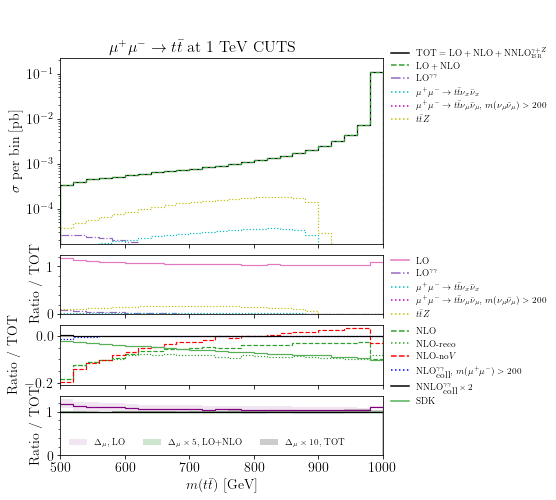

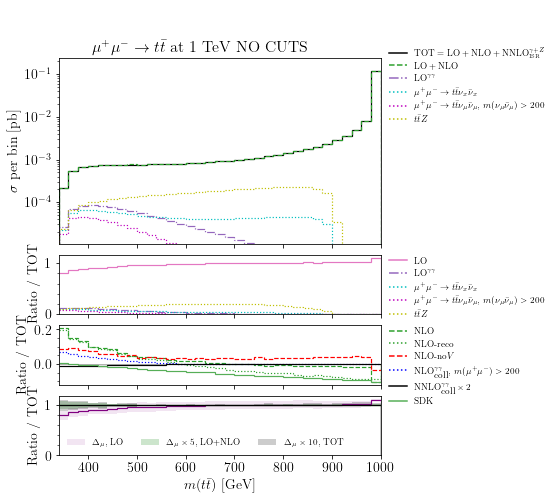

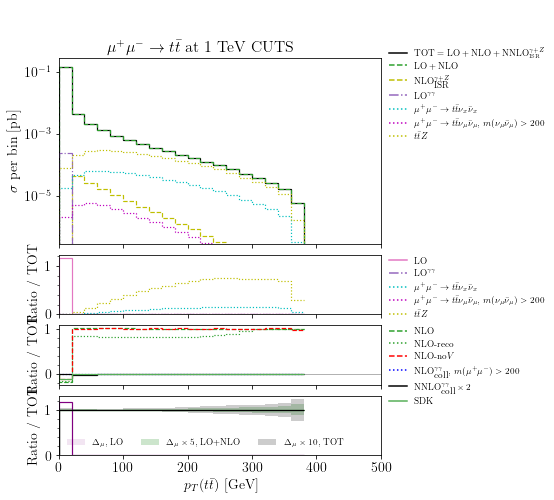

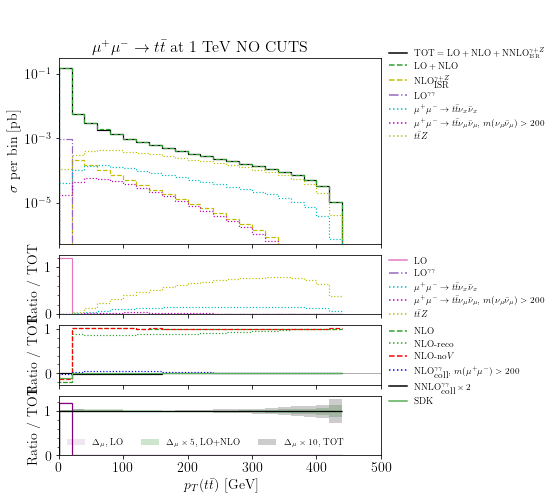

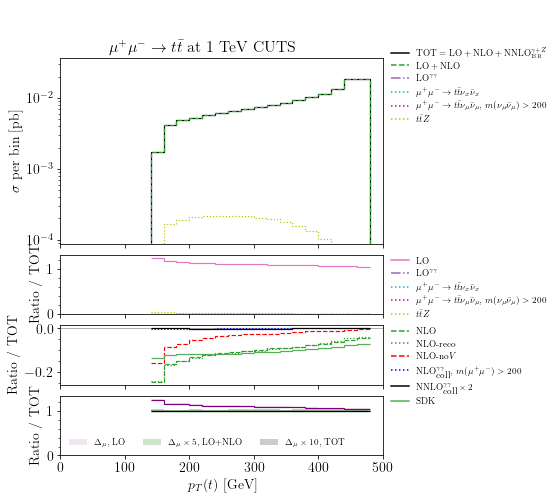

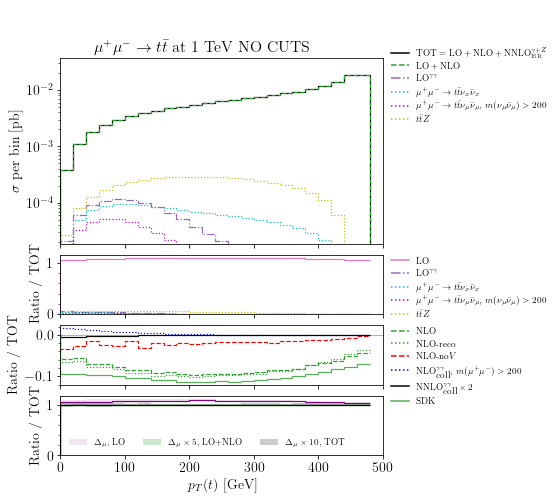

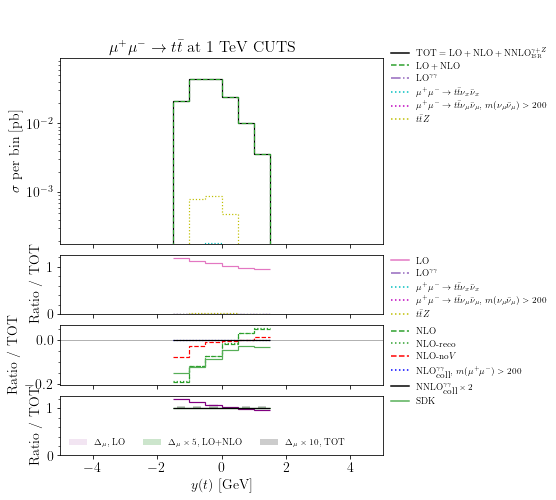

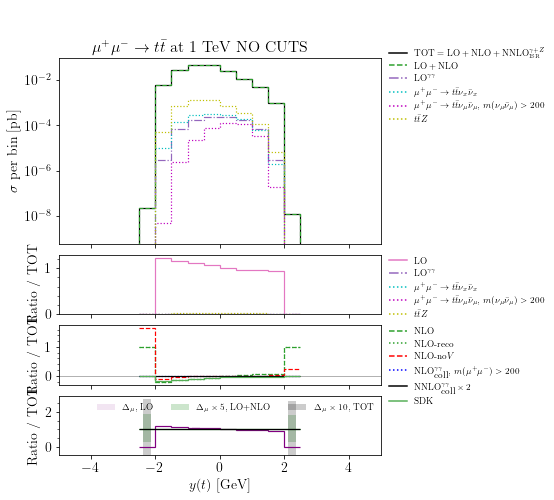

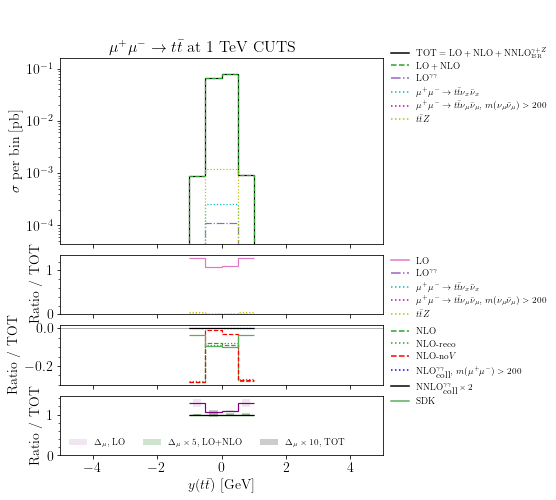

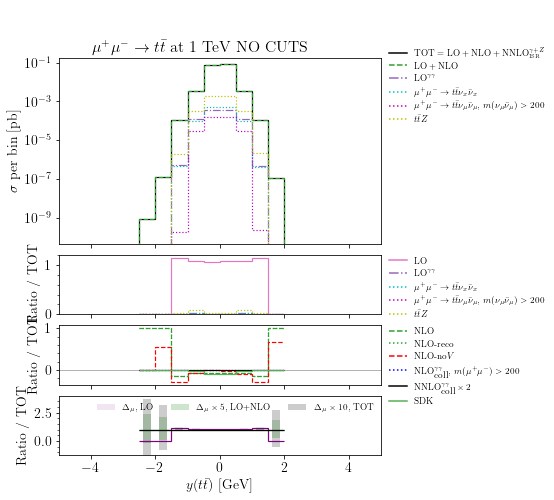

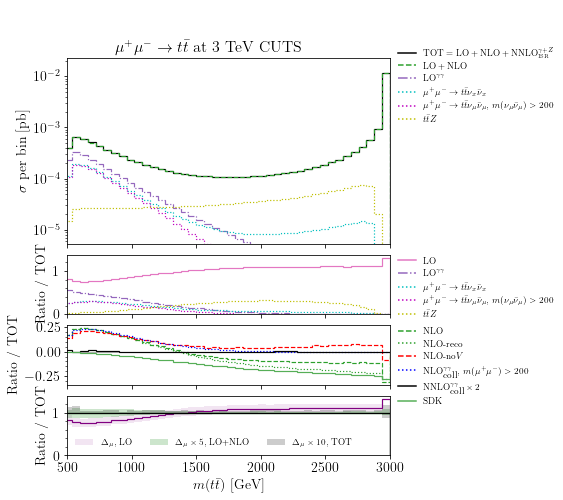

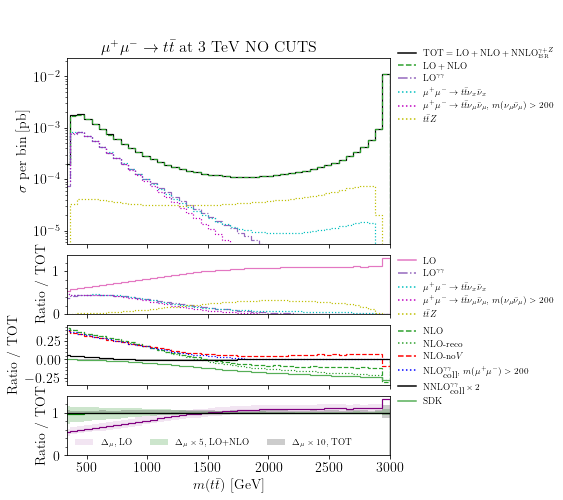

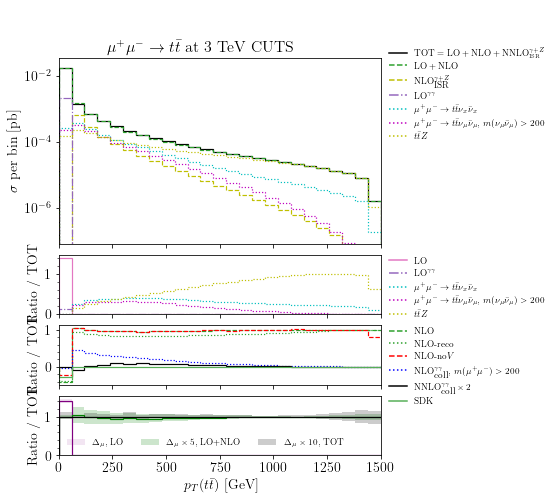

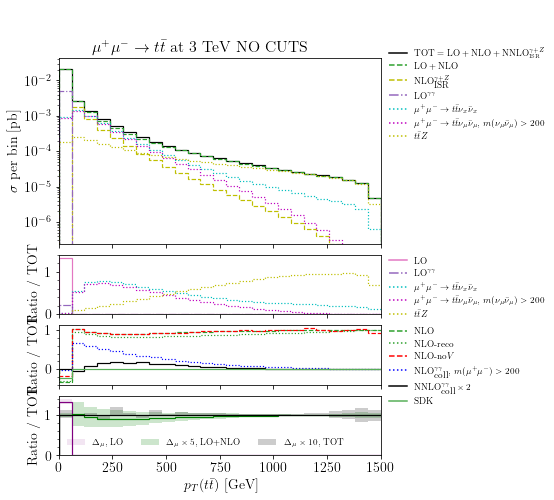

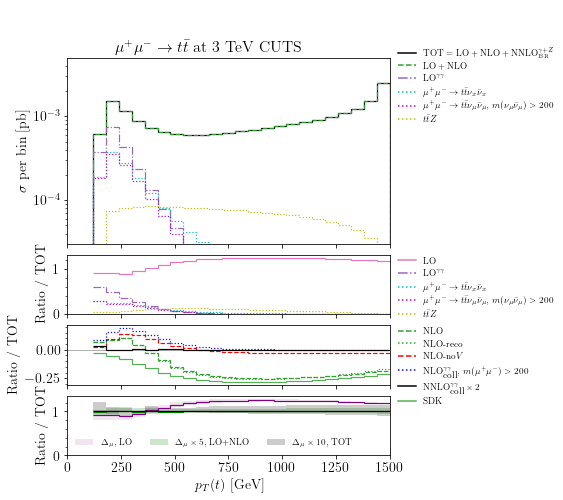

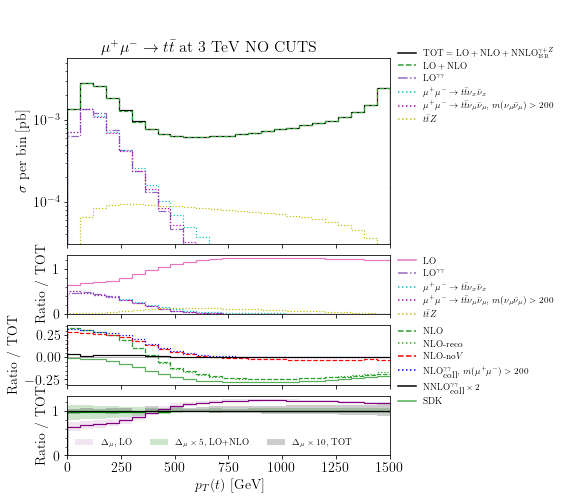

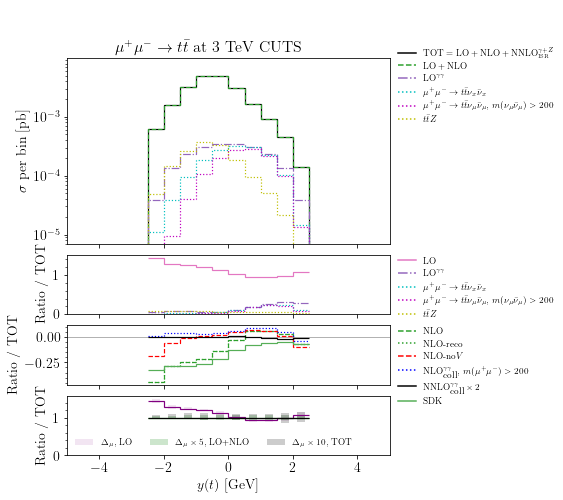

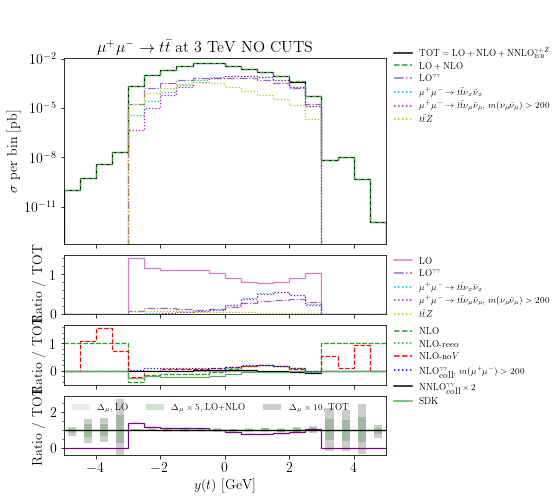

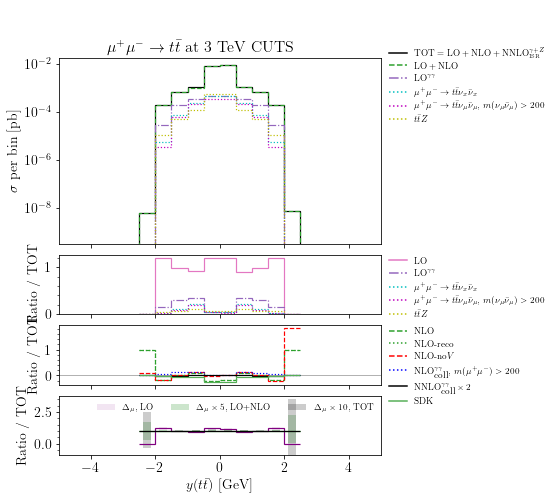

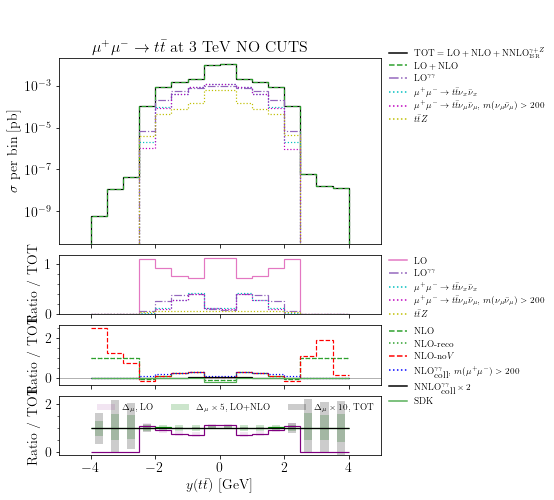

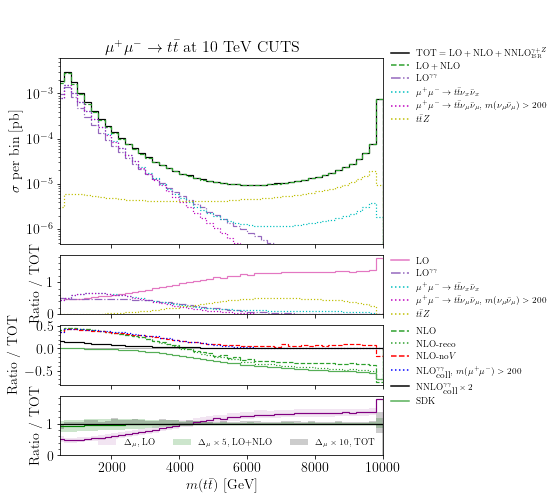

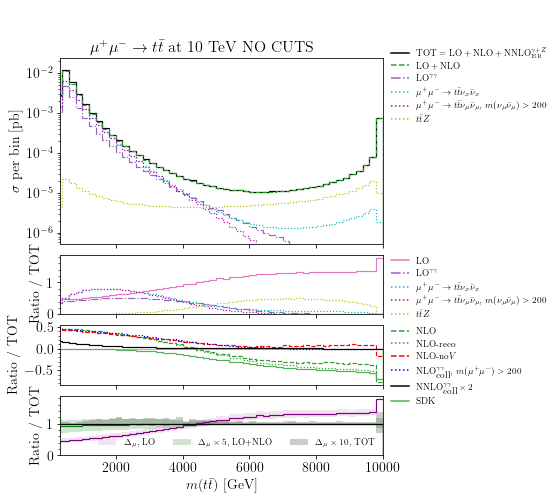

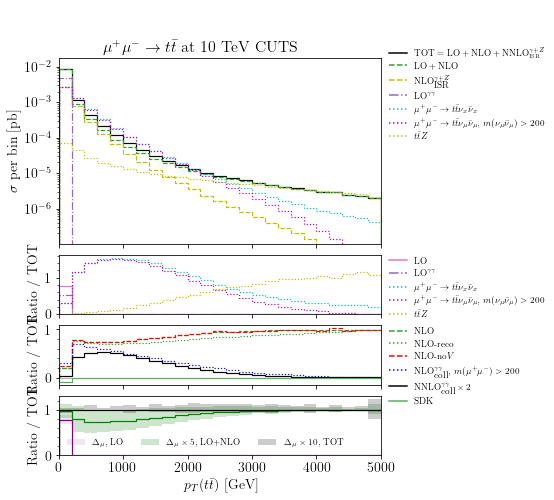

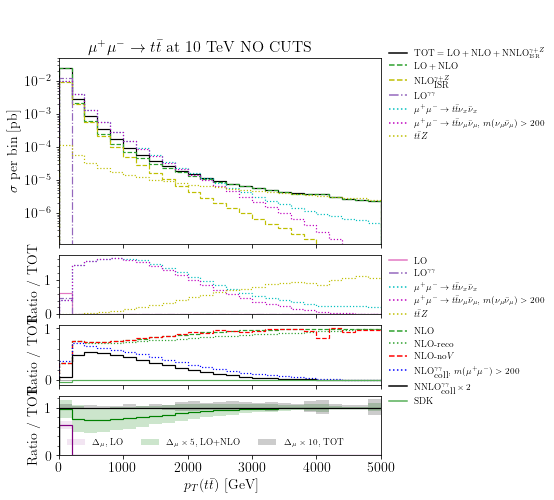

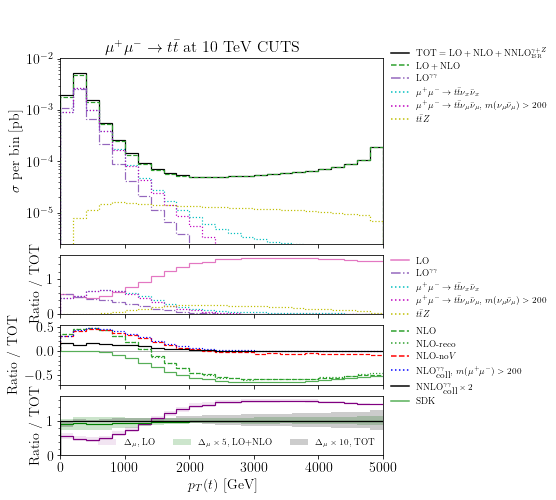

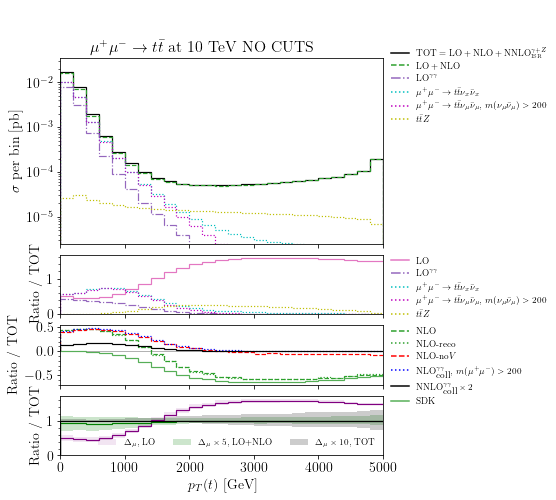

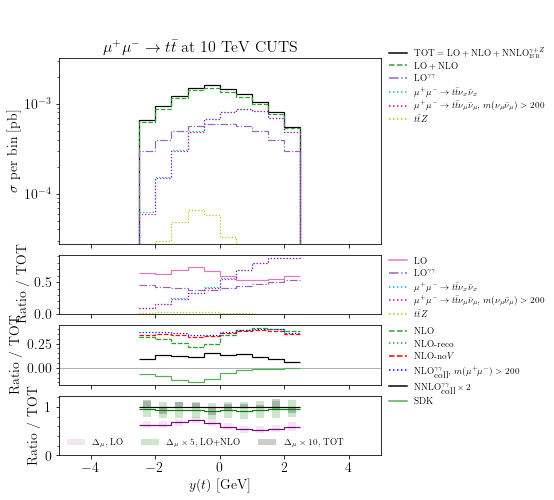

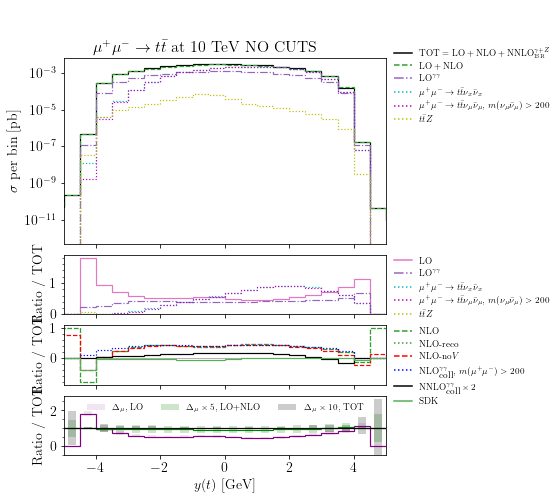

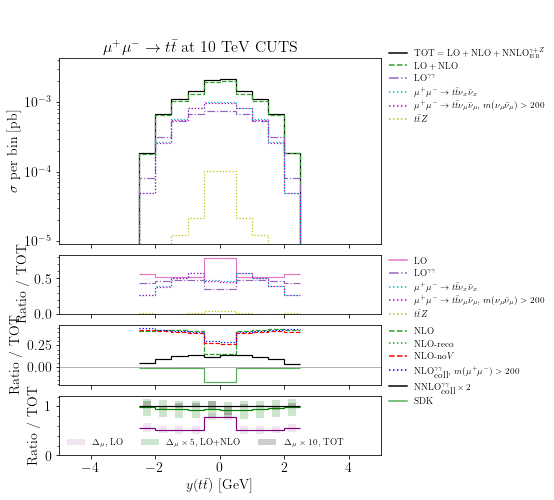

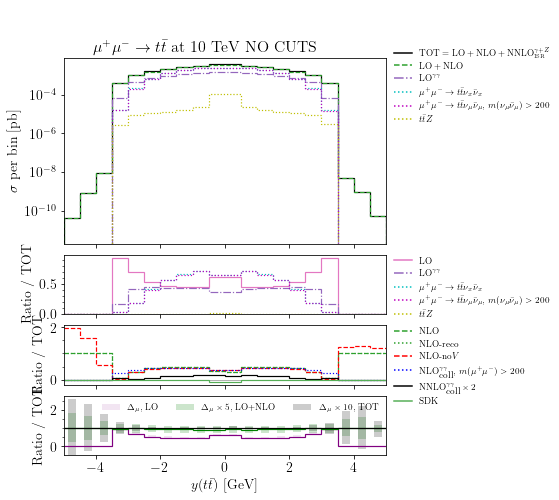

In [82]:
# observables and histograms


energies = [1,3,10]
observables = ['mtt', 'pttt', 'pttop', 'top rap', 'tt rap']
#observables = ['mtt', ]

#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']
#processes = ['ww',]
#energies = [3]
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'

xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}
for p in processes:
    for en in energies:
        fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_cuts' % en, 'MADatNLO.HwU')
        fname_mgnovi = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_novirt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_scdn = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_mufact0.5_cuts' % en, 'MADatNLO.HwU')
        fname_nnlo_scup = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt_mufact2.0_cuts' % en, 'MADatNLO.HwU')
        fname_wbf = os.path.join(p, 'run_Wfusion_%dtev_cuts' % en, 'MADatNLO.HwU')
        fname_ttz = os.path.join(p, 'run_ttZ_%dtev_cuts' % en, 'MADatNLO.HwU')
        fname_sdk = os.path.join(p, 'run_sdk_%dtev_cuts' % en, 'MADatNLO.HwU')

        for o, cut in itertools.product(observables, [True,False]):
            print(p, en, o, cut)
            scut = ''
            if cut:
                scut = 'C'
            try:
                # mg histograms
                h_lo_mg = get_histo_from_file(fname_mg, o, 'LO'+scut)
                h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA'+scut)
                h_nlo_mgnovi = get_histo_from_file(fname_mgnovi, o, 'NLO'+scut)
                h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO'+scut)
                h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR'+scut)
                h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT'+scut)
                # nnlo histograms
                h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO'+scut, scvarfiles = [fname_nnlo_scdn, fname_nnlo_scup])
                
                h_tota = h_nnlo_nnlo + h_tot_mg
            except (FileNotFoundError, HistoNotFound) as e:
                print(e)
                continue
            
            try:
                # wfusion histograms
                h_w_tot = get_histo_from_file(fname_wbf, o, 'LO'+scut)
                h_w_vmcut = get_histo_from_file(fname_wbf, o, 'LOVMX'+scut)
                foundww = True
            except (FileNotFoundError, HistoNotFound):
                print('NOT FOUND', fname_wbf)
                foundww = False
                
            h_z_tot = get_histo_from_file(fname_ttz, o, 'LO'+scut)
            h_sdk = get_histo_from_file(fname_sdk, o, 'SDKW'+scut)

            
            # now the figure
            fig, axes = plt.subplots(nrows = 4, ncols= 1, sharex = True, 
                                     gridspec_kw={'height_ratios': [2.5,0.8,0.8,0.8]})
            fig.set_size_inches(7*0.75,7)
            if cut:
                sscut = 'CUTS'
            else:
                sscut = 'NO CUTS'
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV   %s' % (en, sscut), fontsize=16, y=1.015 ) 
            
            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())
            
            ttz_labels = {'tt': '$t\\bar t Z$', 'ww': '$W^+W^- Z$'}

            #main frame, show absolute xsec
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o in ['pttt', 'pttop']:
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)
                
            if o == 'mtt' and p == 'tt':
                if cut:
                    ax.set_xlim(500,en*1000)
                else:
                    ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                ax.set_xlim(-5,5)
                
            binwidth = obsrange[1]/h_tota['nbins']
            # total
            ax.hist(x = h_tota['x'], weights = h_tota['y'], histtype= 'step', bins = h_tota['nbins'], 
                   label = '$\\textrm{TOT}=\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            ax.hist(x = h_tot_mg['x'], weights = h_tot_mg['y'], histtype= 'step', bins = h_tot_mg['nbins'], 
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)
            
            if o == 'pttt':
                ax.hist(x = h_nlo_nnlo['x'], weights = h_nlo_nnlo['y'], histtype= 'step', bins = h_nlo_nnlo['nbins'], 
                   label = '$\\textrm{NLO}^{\\gamma+Z}_\\textrm{ISR}$',
                   linewidth=lw, color=allcolors[15], linestyle='dashed', range=obsrange)
            
            ax.hist(x = h_loaa_mg['x'], weights = h_loaa_mg['y'], histtype= 'step', bins = h_loaa_mg['nbins'], 
                   label = '$\\textrm{LO}^{\\gamma\\gamma}$',
                   linewidth=lw, color=allcolors[4], linestyle='-.', range=obsrange)
            
            if foundww:
                ax.hist(x = h_w_tot['x'], weights = h_w_tot['y'], histtype= 'step', bins = h_w_tot['nbins'], 
                   linewidth=lw, color=allcolors[13], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_x \\bar \\nu_x$", range=obsrange)
            
                ax.hist(x = h_w_vmcut['x'], weights = h_w_vmcut['y'], histtype= 'step', bins = h_w_vmcut['nbins'], 
                   linewidth=lw, color=allcolors[14], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$", range=obsrange)            
            
            ax.hist(x = h_z_tot['x'], weights = h_z_tot['y'], histtype= 'step', bins = h_z_tot['nbins'], 
                   linewidth=lw, color=allcolors[15], linestyle='dotted',
                   label=ttz_labels[p], range=obsrange)
                
            ax.set_ylim(min([v for v in h_tota['y'] if v !=0])/20, max(h_tota['y'])*2)
            update_legend(ax, ncol=1)

            # inset, lo gamma gamma / lo total
            ax=axes[1]
            ax.set_ylabel("$\\textrm{LO}^{\\gamma\\gamma}/\\textrm{LO}$")
            ax.set_ylabel("Ratio / TOT")
            
            
            h_loratio = h_lo_mg / h_tota
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[6],
                   label="$\\textrm{LO}$", range=obsrange)
            
            h_loratio = h_loaa_mg / h_tota
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[4], linestyle='-.',
                   label="$\\textrm{LO}^{\\gamma\\gamma}$", range=obsrange)
            
            if foundww:
                h_loratio = h_w_tot / h_tota
                ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[13], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_x \\bar \\nu_x$", range=obsrange)
            
                h_loratio = h_w_vmcut / h_tota
                ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[14], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$", range=obsrange)
            
            h_loratio = h_z_tot / h_tota
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[15], linestyle='dotted',
                   label=ttz_labels[p], range=obsrange)
            
            update_legend(ax, ncol=1)

            ax=axes[2]
            # second inset
            ax.set_ylabel("Ratio / TOT")
            ax.hist(x = h_lo_mg['x'], weights = [0]*h_lo_mg['nbins'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   linewidth=lw/2, color='gray', linestyle='solid', range=obsrange)        
    
            h_kfac = h_nlo_mg / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dashed', 
                    label = '$\\textrm{NLO}$', range=obsrange)
            
            h_kfac = h_nlor_mg / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dotted', 
                    label = '$\\textrm{NLO-reco}$', range=obsrange)
            
            h_kfac = h_nlo_mgnovi / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[3], linestyle='dashed', 
                    label = '$\\textrm{NLO-no}V$', range=obsrange)
            
            h_kfac = h_nlo_nnlo / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[10], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, m(\\mu^+\\mu^-)>200$', range=obsrange)
            
            nnlo_rescale = 2
            h_kfac = h_nnlo_nnlo / h_tota * nnlo_rescale
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[1], linestyle='solid', 
                    label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll} \\times %d$' % nnlo_rescale, range=obsrange)
            
            h_kfac = h_sdk / h_tota
            ax.hist(x=h_kfac['x'], weights=h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'],
                     linewidth=lw, color=allcolors[19], linestyle='solid',
                    label ='SDK', range=obsrange)

            
            
            update_legend(ax, ncol=1)
            
            ax = axes[3]
            #ax.set_ylim(0.8,1.2)
            inflate_scale_NLO = 5
            inflate_scale_NNLO = 10

            h_kfac = h_lo_mg / h_tota
            ax.bar(x=h_kfac['x'], bottom=h_kfac.scalelow(), height=h_kfac.scaledelta(), align='center', linewidth=1, color='purple', alpha=0.1, width=binwidth,
                  label = '$\\Delta_\\mu$, LO')#, label='LO')
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='purple', range=obsrange)
            h_kfac = h_tot_mg / h_tota
            ax.bar(x=h_kfac['x'], bottom=h_kfac.scalelow(inflate_scale_NLO), height=h_kfac.scaledelta(inflate_scale_NLO), align='center', linewidth=1, color='green', alpha=0.2, width=binwidth,
                  label='$\\Delta_\\mu\\times%d$, LO+NLO' % inflate_scale_NLO)
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='green', range=obsrange)
            h_kfac = h_tota / h_tota
            ax.bar(x=h_kfac['x'], bottom=h_kfac.scalelow(inflate_scale_NNLO), height=h_kfac.scaledelta(inflate_scale_NNLO), align='center', linewidth=1, color='black', alpha=0.2, width=binwidth,
                   label='$\\Delta_\\mu\\times%d$, TOT' % inflate_scale_NNLO)      
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color='black', range=obsrange)            
            ax.set_ylabel("Ratio / TOT")
            #update_legend(ax, ncol=1)
            ax.legend(prop=font_legend,frameon = False, ncol=3)
            print('TOT RATE NLO', h_tot_mg.totrate)

            ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])
            
            plt.savefig('%s%s_%s_%dtev.pdf' % (o,scut,p,en), bbox_inches = 'tight')

False

In [ ]:
str(float('nan'))